In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading data
path = "pm25_daily.csv"  # change if needed
df_daily = pd.read_csv(path)

# Handling some datatypes
if "datetime_utc" in df_daily.columns:
    dt_col = "datetime_utc"
elif "Unnamed: 0" in df_daily.columns:
    dt_col = "Unnamed: 0"
else:
    # try first column
    dt_col = df_daily.columns[0]

df_daily[dt_col] = pd.to_datetime(df_daily[dt_col], utc=True, errors="coerce")
df_daily = df_daily.rename(columns={"pm25_clean": "pm25"})
df_daily = df_daily.set_index(dt_col).sort_index()

# keeping only target for the univariate approach
df_daily = df_daily[["pm25"]]

print("Shape:", df_daily.shape)
print("Date range:", df_daily.index.min(), "→", df_daily.index.max())
print("Missing days:", int(df_daily["pm25"].isna().sum()))
print("Zero-value days:", int((df_daily["pm25"] == 0).sum()))


Shape: (3207, 1)
Date range: 2016-11-09 00:00:00+00:00 → 2025-08-20 00:00:00+00:00
Missing days: 506
Zero-value days: 1


In [5]:
df_daily.head()

,pm25
Unnamed: 0,
2016-11-09 00:00:00+00:00,311.600000
2016-11-10 00:00:00+00:00,255.458333
2016-11-11 00:00:00+00:00,261.125000
2016-11-12 00:00:00+00:00,228.590909
2016-11-13 00:00:00+00:00,168.625000


# Visualisation with gaps

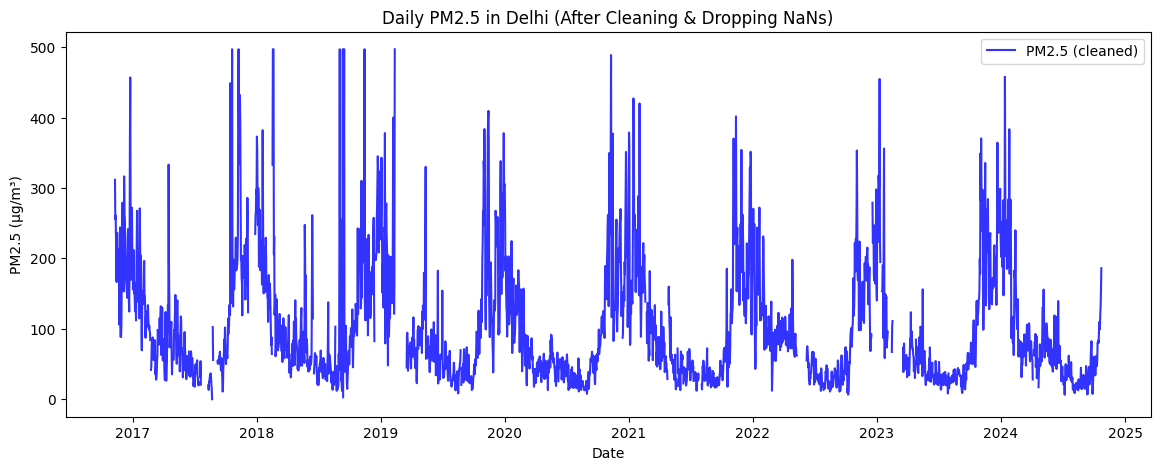

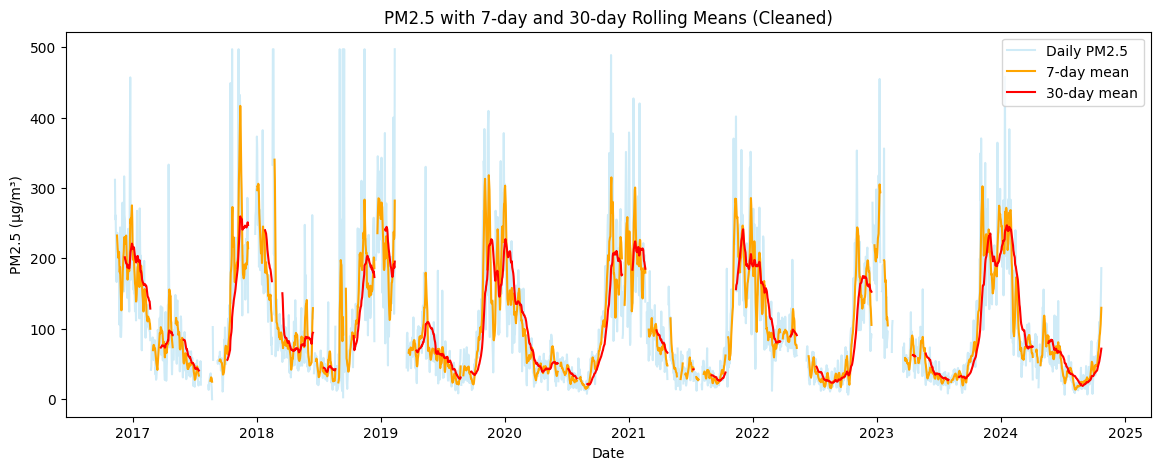

In [ ]:
import matplotlib.pyplot as plt

# PM2.5 plot
plt.figure(figsize=(14,5))
plt.plot(df_daily.index, df_daily["pm25"], label="PM2.5 (cleaned)", color="blue", alpha=0.8)
plt.title("Daily PM2.5 in Delhi (After Cleaning & Dropping NaNs)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()

# Rolling mean
plt.figure(figsize=(14,5))
plt.plot(df_daily.index, df_daily["pm25"], alpha=0.4, label="Daily PM2.5", color="skyblue")
plt.plot(df_daily.index, df_daily["pm25"].rolling(7).mean(), label="7-day mean", color="orange")
plt.plot(df_daily.index, df_daily["pm25"].rolling(30).mean(), label="30-day mean", color="red")
plt.title("PM2.5 with 7-day and 30-day Rolling Means (Cleaned)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()

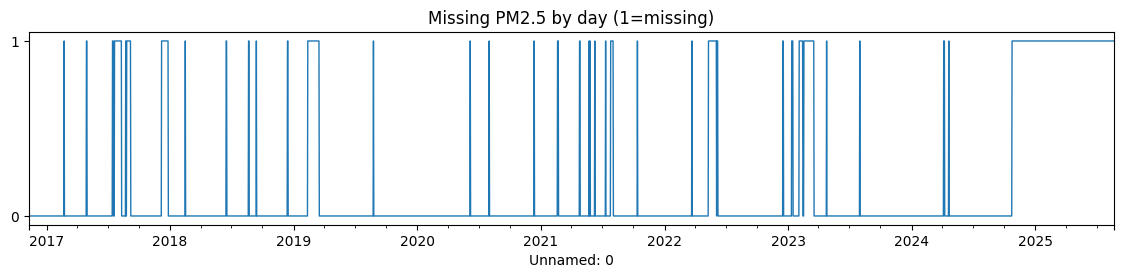

C:\Users\hp\AppData\Local\Temp\ipykernel_8652\228181674.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cal["ym"] = cal.index.to_period("M")


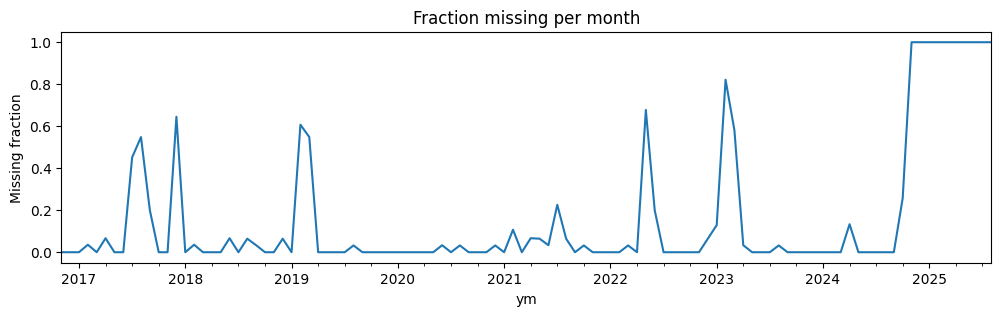

In [ ]:
# Missing map over time
plt.figure(figsize=(14,2.5))
df_daily["pm25"].isna().astype(int).plot(lw=1)
plt.title("Missing PM2.5 by day (1=missing)")
plt.yticks([0,1])
plt.show()

# Fraction missing by year-month
miss = df_daily["pm25"].isna().astype(int)
cal = miss.to_frame("miss")
cal["ym"] = cal.index.to_period("M")
by_month = cal.groupby("ym")["miss"].mean()
plt.figure(figsize=(12,3))
by_month.plot()
plt.title("Fraction missing per month")
plt.ylabel("Missing fraction")
plt.show()


In [ ]:
s = df_daily["pm25"].fillna(np.inf)  # keep NaNs separate from zeros
is_zero = (s == 0).astype(int)

# consecutive zeros
groups = (is_zero != is_zero.shift()).cumsum()
zero_run_lengths = is_zero.groupby(groups).sum()
max_zero_run = int(zero_run_lengths[is_zero.groupby(groups).first() == 1].max() or 0)
zero_days = int((df_daily["pm25"] == 0).sum())

print("Zero days total:", zero_days, "| Longest consecutive zero run (days):", max_zero_run)


Zero days total: 1 | Longest consecutive zero run (days): 1


In [ ]:
dfc = df_daily.copy()

# making zero as missing because its mostly not zero in Delhi
dfc.loc[dfc["pm25"] == 0, "pm25"] = np.nan

# Removing very high values
dfc.loc[dfc["pm25"] < 0, "pm25"] = np.nan
dfc.loc[dfc["pm25"] > 600, "pm25"] = np.nan  

# Hybrid imputation
# ffill or bfill for short gaps
dfc["pm25"] = dfc["pm25"].ffill(limit=7).bfill(limit=7)

# linear interpolation for medium gaps
dfc["pm25"] = dfc["pm25"].interpolate(method="time", limit=30)

# final NA values
remaining_nans = int(dfc["pm25"].isna().sum())
print("Remaining NaNs after hybrid imputation:", remaining_nans)


Remaining NaNs after hybrid imputation: 264


In [12]:
dfc.head()

,pm25
Unnamed: 0,
2016-11-09 00:00:00+00:00,311.600000
2016-11-10 00:00:00+00:00,255.458333
2016-11-11 00:00:00+00:00,261.125000
2016-11-12 00:00:00+00:00,228.590909
2016-11-13 00:00:00+00:00,168.625000


In [13]:
dfc = dfc.dropna(subset=["pm25"])


In [18]:
dfc.head()

,pm25
Unnamed: 0,
2016-11-09 00:00:00+00:00,311.600000
2016-11-10 00:00:00+00:00,255.458333
2016-11-11 00:00:00+00:00,261.125000
2016-11-12 00:00:00+00:00,228.590909
2016-11-13 00:00:00+00:00,168.625000


# After Handling nans

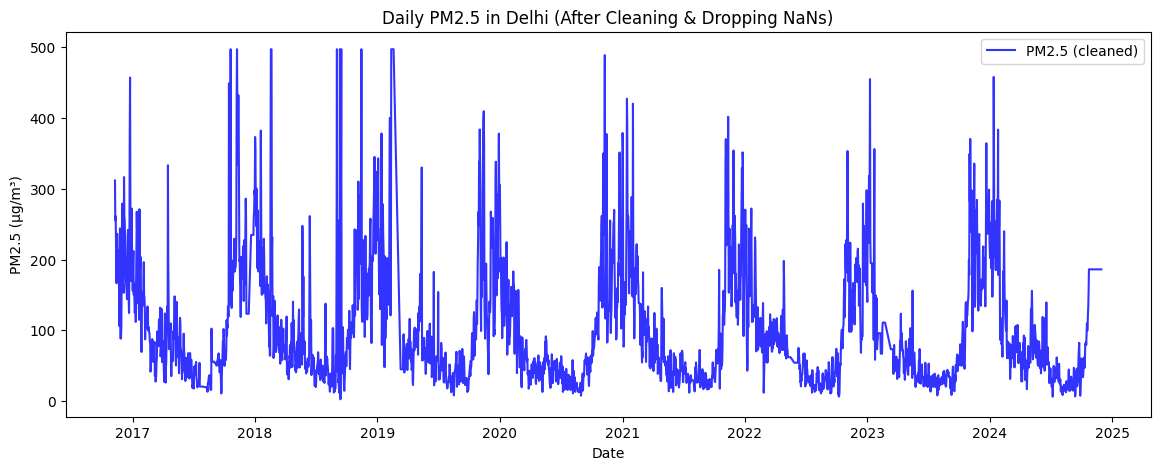

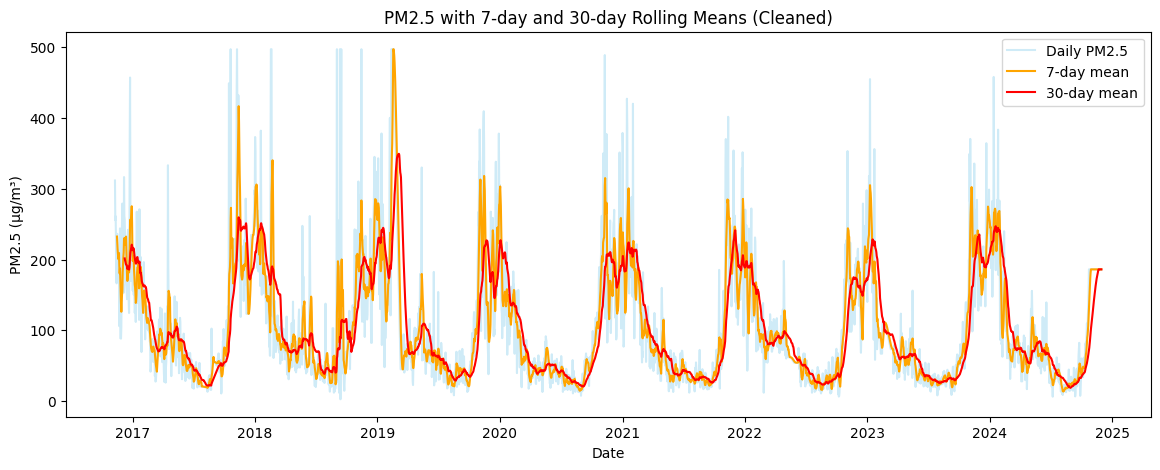

In [19]:
import matplotlib.pyplot as plt

# Plot final PM2.5 daily series
plt.figure(figsize=(14,5))
plt.plot(dfc.index, dfc["pm25"], label="PM2.5 (cleaned)", color="blue", alpha=0.8)
plt.title("Daily PM2.5 in Delhi (After Cleaning & Dropping NaNs)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()

# Plot rolling means for clarity
plt.figure(figsize=(14,5))
plt.plot(dfc.index, dfc["pm25"], alpha=0.4, label="Daily PM2.5", color="skyblue")
plt.plot(dfc.index, dfc["pm25"].rolling(7).mean(), label="7-day mean", color="orange")
plt.plot(dfc.index, dfc["pm25"].rolling(30).mean(), label="30-day mean", color="red")
plt.title("PM2.5 with 7-day and 30-day Rolling Means (Cleaned)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()


In [21]:
dfc.head()

,pm25
Unnamed: 0,
2016-11-09 00:00:00+00:00,311.600000
2016-11-10 00:00:00+00:00,255.458333
2016-11-11 00:00:00+00:00,261.125000
2016-11-12 00:00:00+00:00,228.590909
2016-11-13 00:00:00+00:00,168.625000


# Missing values after cleaning

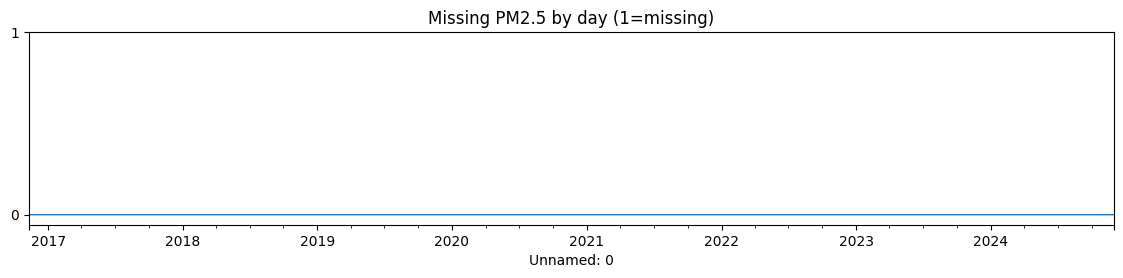

C:\Users\hp\AppData\Local\Temp\ipykernel_8652\2448588787.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cal["ym"] = cal.index.to_period("M")


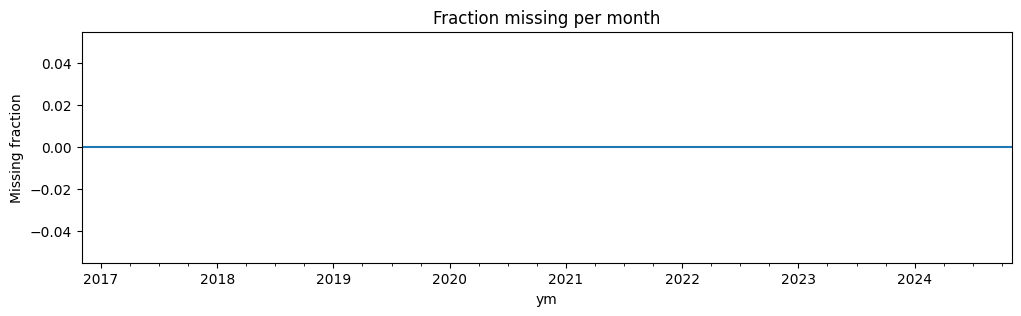

In [22]:
# Missing map over time (1 = missing)
plt.figure(figsize=(14,2.5))
dfc["pm25"].isna().astype(int).plot(lw=1)
plt.title("Missing PM2.5 by day (1=missing)")
plt.yticks([0,1])
plt.show()

# Fraction missing by year-month
miss = dfc["pm25"].isna().astype(int)
cal = miss.to_frame("miss")
cal["ym"] = cal.index.to_period("M")
by_month = cal.groupby("ym")["miss"].mean()
plt.figure(figsize=(12,3))
by_month.plot()
plt.title("Fraction missing per month")
plt.ylabel("Missing fraction")
plt.show()


In [27]:
dfc.isna().sum()

pm25    0
dtype: int64

In [ ]:
# Dropping long-gap NaNs
dfc_final = dfc.dropna(subset=["pm25"])
print("Final shape:", dfc_final.shape)

# Saving the final cleaned csv data
dfc_final.to_csv("pm25_daily_final.csv", index=True)


Final shape: (2943, 1)
